In [ ]:
import spcm
from spcm import units
import numpy as np
from atommovr_yuanzhe.atommover.utils import Move


def shape_linear(x):
    return x

def shape_cosine(x):
    return 0.5-0.5*np.cos(np.pi*x)

def shape_square(x):
    return np.where(x < 0.5, 0, 1)




class Serial_AOD_2D_DDS():
    def __init__(self, card: spcm.Card, core_number_x: int, core_number_y: int, f_list_x: np.ndarray, f_list_y: np.ndarray):
        self.card = card
        self.core_number_x = core_number_x
        self.core_number_y = core_number_y
        self.f_list_x = f_list_x
        self.f_list_y = f_list_y
    def allocate_cores(self):
        cores_y_available = [
            spcm.SPCM_DDS_CORE8, spcm.SPCM_DDS_CORE9, spcm.SPCM_DDS_CORE10, 
            spcm.SPCM_DDS_CORE11, spcm.SPCM_DDS_CORE20
        ]
        self.core_list_y = cores_y_available[-self.core_number_y:]
        cores_x_available = [
            spcm.SPCM_DDS_CORE0, spcm.SPCM_DDS_CORE1, spcm.SPCM_DDS_CORE2,                      
            spcm.SPCM_DDS_CORE3, spcm.SPCM_DDS_CORE4, spcm.SPCM_DDS_CORE5,      
            spcm.SPCM_DDS_CORE6, spcm.SPCM_DDS_CORE7, spcm.SPCM_DDS_CORE12, 
            spcm.SPCM_DDS_CORE13, spcm.SPCM_DDS_CORE14, spcm.SPCM_DDS_CORE15,
            spcm.SPCM_DDS_CORE16, spcm.SPCM_DDS_CORE17, spcm.SPCM_DDS_CORE18,
            spcm.SPCM_DDS_CORE19
        ]
        self.core_list_x = cores_x_available[0:self.core_number_x]
    def card_setup(self):
        self.card.card_mode(spcm.SPC_REP_STD_DDS)
        channels = spcm.Channels(self.card)
        channels.enable(True)
        channels.output_load(50 * units.ohm)
        channels.amp(1 * units.V)
        self.card.write_setup() # IMPORTANT! this turns on the card's system clock signals, that are required for DDS to work
        
        self.dds = spcm.DDS(self.card, channels=channels)
        self.dds.reset()
        self.dds.cores_on_channel(1,*self.core_list_y)

        self.dds.freq_ramp_stepsize(1000)      #Tune the number of steps for frequency ramping 
        self.dds.trg_timer(5.0 * units.s)      #Set a waiting time for rearrangement
        self.dds.trg_src(spcm.SPCM_DDS_TRG_SRC_TIMER)

    def single_movement_batch(self,DDS_core_list,freq_init_list:np.ndarray, freq_final_list:np.ndarray, duration, num_segments, shape):
        frequency_range_list = freq_final_list - freq_init_list
        unit_slices_in = np.linspace(0, 1, num_segments+1, endpoint=True)
        unit_slices_out = shape(unit_slices_in)
        time_list = unit_slices_in*duration
        output_list = np.outer(frequency_range_list, unit_slices_out) 
        # t_diff = np.diff(time_list)     duration_segment may not be a constant
        y_diff = np.diff(output_list)
        duration_segment = duration / num_segments 

        for j in range(len(DDS_core_list)):  # Initialize frequencies, amplitudes and phases    
            DDS_core_list[j].frequency(freq_init_list[j])
            DDS_core_list[j].amp(45 * units.percent / 20) #???
            DDS_core_list[j].phase(180*np.random.rand()*units.degrees)
        self.dds.exec_at_trg()
        self.dds.write_to_card()

        self.dds.trg_timer(duration_segment)   # Ramp the shape
        for i in range(num_segments):
            for j in range(len(DDS_core_list)):
                DDS_core_list[j].frequency_slope(y_diff[j][i] /duration_segment) 
            self.dds.exec_at_trg()

        for j in range(len(DDS_core_list)):
            DDS_core_list[j].frequency_slope(0) # Stop frequency ramping, may be later also amplitude shut down??
            DDS_core_list[j].freq(freq_final_list[j])
            DDS_core_list[j].phase(180*np.random.rand()*units.degrees)
        self.dds.exec_at_trg()
        self.dds.write_to_card()

    def wait(self):
        self.card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_CARD_FORCETRIGGER)
        input("Press Enter to Exit")

    def rearrange(self,move_sequence: list[Move]):
        for move in move_sequence:
            freq_x_init = self.f_list_x[move.from_row]
            freq_y_init = self.f_list_y[move.from_col]
            freq_x_final = self.f_list_x[move.to_row]   
            freq_y_final = self.f_list_y[move.to_col]
            self.single_movement_batch(
                [self.core_list_x[0], self.core_list_y[0]],   # Currently only one core in each direction, one finger kungfu
                np.array([freq_x_init, freq_y_init]),
                np.array([freq_x_final, freq_y_final]),
                1*units.ms,
                10,
                shape_linear
            )

Array initialization time: 0.0001 seconds
Tweezer loading time: 0.0001 seconds
Target generation time: 0.0002 seconds


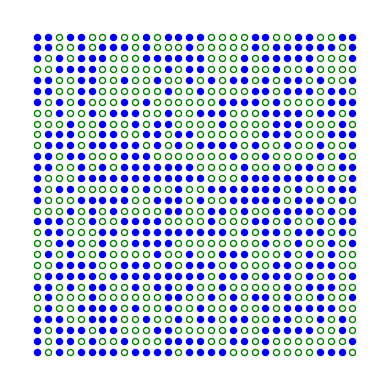

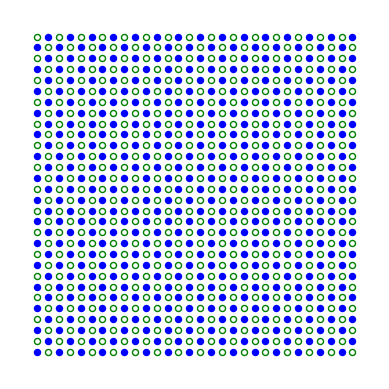

Visualization time: 0.0620 seconds
Algorithm initialization time: 0.0000 seconds
Move sequence calculation time: 0.0625 seconds

Total execution time: 0.1259 seconds
Number of moves: 3
(array([[0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1

In [3]:
import time
from atommover.utils import PhysicalParams
from atommover.utils import AtomArray      
from atommover.algorithms import Hungarian

# Start timing
start_time = time.time()

# specifying parameters
load_prob = 0.5 # float; the probability that an individual site will be loaded
array_length = 30 # int; number of rows (or cols) of the square array

params = PhysicalParams(loading_prob = load_prob)

# Time array initialization
init_start = time.time()
atom_array_1 = AtomArray([array_length, array_length], 1, params)
init_time = time.time() - init_start
print(f"Array initialization time: {init_time:.4f} seconds")

# Time tweezer loading
load_start = time.time()
atom_array_1.load_tweezers()
load_time = time.time() - load_start
print(f"Tweezer loading time: {load_time:.4f} seconds")

# Time target generation
target_start = time.time()
atom_array_1.generate_target()
target_time = time.time() - target_start
print(f"Target generation time: {target_time:.4f} seconds")

# Time visualization
viz_start = time.time()
atom_array_1.image()
atom_array_1.plot_target_config()
viz_time = time.time() - viz_start
print(f"Visualization time: {viz_time:.4f} seconds")

# Time algorithm
algo_start = time.time()
algo1 = Hungarian()  
algo_init_time = time.time() - algo_start
print(f"Algorithm initialization time: {algo_init_time:.4f} seconds")

# Time move calculation
moves_start = time.time()
move_sequence = algo1.get_moves(atom_array_1)
moves_time = time.time() - moves_start
print(f"Move sequence calculation time: {moves_time:.4f} seconds")

# Total time
total_time = time.time() - start_time
print(f"\nTotal execution time: {total_time:.4f} seconds")
print(f"Number of moves: {len(move_sequence) if move_sequence else 0}")
print(move_sequence)